In [1]:
!nvidia-smi

Mon Dec  3 16:12:57 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             On   | 00000000:03:00.0 Off |                  N/A |
| 28%   26C    P8    23W / 250W |      0MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  On   | 00000000:83:00.0 Off |                    0 |
| N/A   27C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

First, we grab matplotlib, and set the old "classic" style for some reason only Rui knows.

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('classic')

In [3]:
import numpy as np
import torch

These are the local imports. Make sure you import the correct model!

In [4]:
from model.models import SimpleCNN3Layer as Model
from model.collectdata import collect_data, collect_truth
from model.training import select_gpu
from model.plots import plot_ruiplot
from model.efficiency import pv_locations, efficiency
from model.core import modernize

Select a GPU here. Same numbering as the NVidia-SMI tool.

In [5]:
device = select_gpu(2)

1 available GPUs (initially using device 0):
  0 TITAN V


Pick a file to load.

In [6]:
validation = collect_data('data/Oct03_20K_val.h5',
                          batch_size=1,
                          slice=slice(100),
                          masking=True,
                          device=device)

Loading data...
Loaded data/Oct03_20K_val.h5 in 2.698 s
Constructing 100 event dataset took 3.503 s


> Note: to get the real PV locations, use `collect_truth('file.h5', pvs=True)` to collect PVs (or SVs with `pvs=False`)

Let's just see how many NaNs we have in the dataset.

In [7]:
print(*np.sum(np.isnan(validation.dataset.tensors[1].cpu().numpy()), 1))

16 6 0 12 18 28 29 12 23 16 17 79 20 18 37 0 12 43 11 21 38 0 35 23 22 22 23 33 27 16 0 23 17 56 17 38 16 45 12 12 12 22 22 11 12 44 17 45 6 17 39 28 33 17 39 62 53 29 6 6 5 46 53 34 22 29 17 63 17 12 18 22 50 18 28 12 41 29 22 34 35 17 42 11 57 27 16 22 23 33 23 33 16 45 30 0 6 16 28 17


In [8]:
PV = collect_truth('data/Oct03_20K_val.h5', pvs=True)
print('PV.n.shape =    ',  PV.n.shape)
print('PV.n[0].shape = ', *PV.n[0].shape)
print('PV.x[0] =       ', *PV.x[0])
print('PV.y[0] =       ', *PV.y[0])
print('PV.z[0] =       ', *PV.z[0])
print('PV.n[0] =       ', *PV.n[0])
print('PV.cat[0] =     ', *PV.cat[0])

Loaded data/Oct03_20K_val.h5 in 0.05525 s
PV.n.shape =     (20000,)
PV.n[0].shape =  7
PV.x[0] =        0.0067699254 -0.05386329 0.0018882935 -0.035012268 -0.010384369 0.045956675 -0.073287025
PV.y[0] =        0.00076032506 -0.001020242 -0.03236149 0.043514606 -0.08862019 -0.06502226 -0.0052683405
PV.z[0] =        163.4873 80.101074 1.0544614 -36.59213 115.55979 48.95428 126.700806
PV.n[0] =        34 10 4 23 4 29 4
PV.cat[0] =      1 1 0 1 0 1 0


In [9]:
PV.n.max().max()

96

In [10]:
PV.cat[0]

array([1, 1, 0, 1, 0, 1, 0], dtype=int8)

In [11]:
SV = collect_truth('data/Oct03_20K_val.h5', pvs=False)
print('SV.n.shape =    ', SV.n.shape)
print('SV.n[0].shape = ', *SV.n[0].shape)
print('SV.x[0] =       ', *SV.x[0])
print('SV.y[0] =       ', *SV.y[0])
print('SV.z[0] =       ', *SV.z[0])
print('SV.n[0] =       ', *SV.n[0])
print('SV.cat[0] =     ', *SV.cat[0])

Loaded data/Oct03_20K_val.h5 in 0.02661 s
SV.n.shape =     (20000,)
SV.n[0].shape =  8
SV.x[0] =        0.010110953 0.0021237247 0.045436032 0.20971942 -0.16212782 0.0306345 -0.036008105 0.023469282
SV.y[0] =        0.004470912 -0.03932457 -0.018049993 -0.007921243 -0.09059714 -0.084428996 0.062232733 -0.017153485
SV.z[0] =        163.6645 150.67242 163.82443 55.91566 223.25316 85.7269 -37.02821 -96.02165
SV.n[0] =        1 0 2 0 0 0 1 0
SV.cat[0] =      0 -1 1 -1 -1 -1 0 -1


Select a model to load. Make sure it matches the model you imported above.

In [12]:
name = '../notebooks/Nov_27_mask_16K_3layer/Nov_27_mask_16K_3layer_50.pyt'
model = Model().to(device)
d = torch.load(name)
d = modernize(d) # Only use if using the new Model definitions (should be safe if not, but unneccisary)
model.load_state_dict(d)
model.eval()

SimpleCNN3Layer(
  (features): Sequential(
    (0): Conv1d(1, 10, kernel_size=(25,), stride=(1,), padding=(12,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv1d(10, 5, kernel_size=(15,), stride=(1,), padding=(7,))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv1d(5, 1, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Dropout(p=0.35)
  )
  (fc): Linear(in_features=4000, out_features=4000, bias=True)
)

Let's grab the outputs and labels as normal numpy arrays.

In [13]:
%%time
with torch.no_grad():
    outputs = model(validation.dataset.tensors[0]).cpu().numpy()
    labels = validation.dataset.tensors[1].cpu().numpy()

CPU times: user 830 µs, sys: 8.46 ms, total: 9.29 ms
Wall time: 8 ms


And here's Rui's plotting code.


Event 0: Found 3 of 4, added 0 (eff 75.00%)

Event 0.0:

PV: 23 tracks (type 1)
  x:   -0.035 mm
  y:    0.044 mm
  z:  -36.592 mm

SV: 1 tracks (type 0)
  x:   -0.036 mm
  y:    0.062 mm
  z:  -37.028 mm


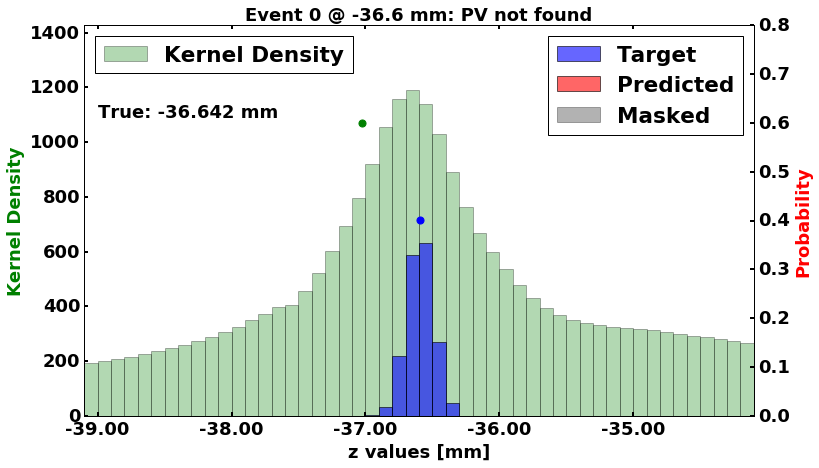


Event 0.1:

PV: 29 tracks (type 1)
  x:    0.046 mm
  y:   -0.065 mm
  z:   48.954 mm


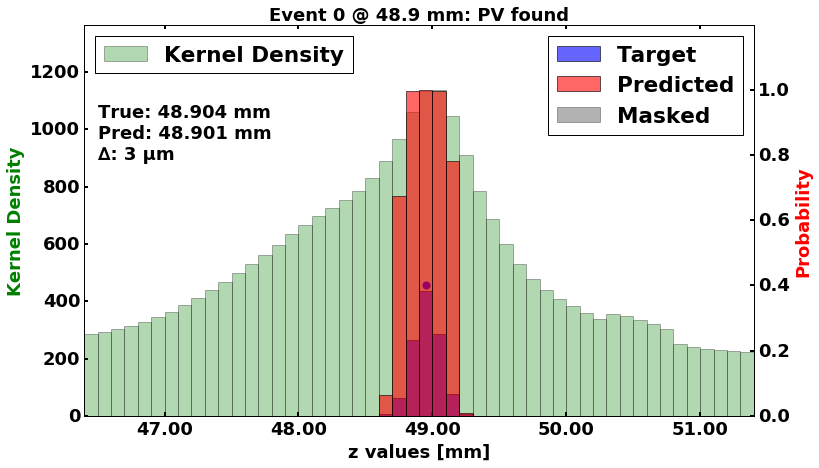


Event 0.2:

PV: 10 tracks (type 1)
  x:   -0.054 mm
  y:   -0.001 mm
  z:   80.101 mm


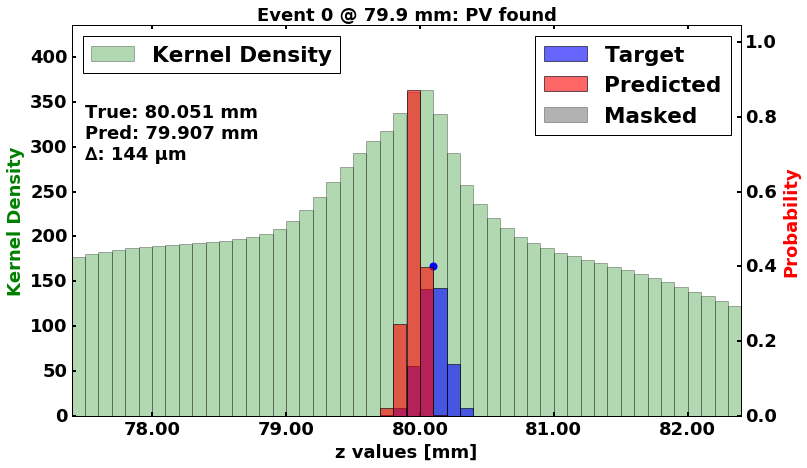


Event 0.3:

PV: 34 tracks (type 1)
  x:    0.007 mm
  y:    0.001 mm
  z:  163.487 mm

SV: 1 tracks (type 0)
  x:    0.010 mm
  y:    0.004 mm
  z:  163.665 mm

SV: 2 tracks (type 1)
  x:    0.045 mm
  y:   -0.018 mm
  z:  163.824 mm


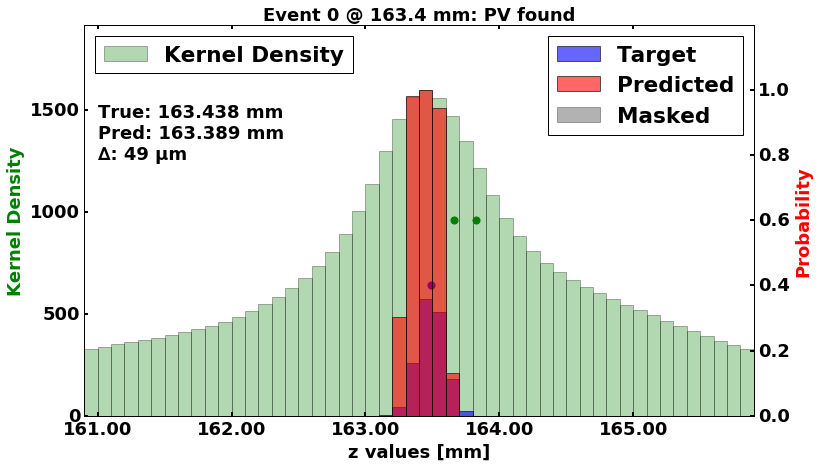

Event 0: Found 3 of 4, added 0 (eff 75.00%)


In [14]:
inputs = validation.dataset.tensors[0].cpu().numpy().squeeze()
zvals = np.linspace(-100, 300, 4000, endpoint=False) + 0.05
finalmsg = ''
internal_count = 0
output_filename = None # Or set: '120000_3layer_{number:02}.pdf'

for event in range(1):
    input = inputs[event]
    label = labels[event]
    output = outputs[event]
    
    # Consistent parameters for the calls below
    parameters = {
        "threshold": 1e-2,
        "integral_threshold": .2,
        "min_width": 3
    }
    
    # Compute the "actual" efficenies and things
    ftruth = pv_locations(label, **parameters)
    fcomputed = pv_locations(output, **parameters)
    results = efficiency(label, output, difference=5.0, **parameters)
    
    # Add a line to the final results string (print at end)
    finalmsg += f"Event {event}: {results}"
    
    # Make sure bin numbers are integers
    truth = np.around(ftruth).astype(np.int32)
    computed = np.around(fcomputed).astype(np.int32)
    
    # Join arrays and remove any points closer than 5 bins
    # We plot over these "points of interest"
    poi = np.sort(np.concatenate([truth, computed]))
    poi = poi[np.concatenate([[True], np.fabs(np.diff(poi)) > 5])]
    
    print(f"\nEvent {event}:", results)
    
    for index, i in enumerate(poi):
        # Convert to location in z
        center = (i / 10) - 100
        
        # Collect items less than 5 apart as "true"
        b_truth = np.fabs(ftruth - i) <= 5
        b_comp = np.fabs(fcomputed - i) <= 5
        in_truth = np.any(b_truth)
        in_comp = np.any(b_comp)
        
        if in_truth and in_comp:
            msg = 'PV found'
        elif in_truth:
            msg = 'PV not found'
        elif False:
            pass # Check for NaNs
        else:
            msg = 'False positive'
            
        with plt.style.context({
            'font.size':18,
            'font.weight':'bold'}):
        
            # ax1 is the axis that is tied to left (density)
            # ax2 is the axis that is tied to the right (probability)
            ax1, ax2 = plot_ruiplot(zvals, i, input, label, output)
            ax1.set_title(f"Event {event} @ {center:.1f} mm: {msg}",
                          fontdict={'size':18, 'weight':'bold'})


            msg = ""
            
            truth_centroid = (ftruth[b_truth] / 10) - 100
            for value in truth_centroid:
                msg += f"True: {value:.3f} mm\n"
                
            comp_centroid = (fcomputed[b_comp] / 10) - 100
            for value in comp_centroid:
                msg += f"Pred: {value:.3f} mm\n"
                
            if len(truth_centroid) == 1 and len(comp_centroid) == 1:
                diff = np.fabs(truth_centroid[0] - comp_centroid[0]) * 1_000
                msg += f"∆: {diff:.0f} µm\n"
            
            ax1.text(.02, .8, msg,
                     transform=ax1.transAxes,
                     verticalalignment='top')
            
            print(f"\nEvent {event}.{index}:")
            
            # Plot and print PVs
            ax2.scatter(PV.z[event], np.ones_like(PV.z[event])*.4, s=50, color='C0')
            for x,y,z,n,cat in zip(PV.x[event], PV.y[event], PV.z[event], PV.n[event], PV.cat[event]):
                # Only print out if z in plotting range
                if center - 2.5 < z < center + 2.5:
                    print()
                    print(f'PV: {n} tracks (type {cat})')
                    print(f'  x: {x:8.3f} mm')
                    print(f'  y: {y:8.3f} mm')
                    print(f'  z: {z:8.3f} mm')
                    

            # Plot and print SVs
            ax2.scatter(SV.z[event], np.ones_like(SV.z[event])*.6, s=50, color='C1')
            for x,y,z,n,cat in zip(SV.x[event], SV.y[event], SV.z[event], SV.n[event], SV.cat[event]):
                # Only print out if z in plotting range
                if center - 2.5 < z < center + 2.5:
                    print()
                    print(f'SV: {n} tracks (type {cat})')
                    print(f'  x: {x:8.3f} mm')
                    print(f'  y: {y:8.3f} mm')
                    print(f'  z: {z:8.3f} mm')

            # Save and show
            if output_filename:        
                plt.savefig(output_filename.format(number=internal_count))
            plt.show()
            
            internal_count += 1
            
print(finalmsg)

In [15]:
exit()